Note: to save runtime in this notebook, only 7 test dates are presented. To examine the entire test period, leverage paralell computing techniques (since the for loops going through the test dates are essentially parallel operations); cannot use gpu to speed up the process because the task is primarily time series and cannot leverage benefits from gpu. The result for the full test period is in the results folder, with graphs under the visuals sub-folder.

In [ ]:
pip install panda numpy statsmodels matplotlib seaborn scipy requests

/Users/leyixu/Desktop


/var/folders/ns/hcbvd_hd3gxfr2y183d8csgr0000gn/T/ipykernel_17557/1131616842.py:21: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['date'] = pd.to_datetime(data['date'])


Optimal number of features: 6
Selected features: ['China: Consumer Confidence Index: Employment:PoP chg', 'China: Consumer Satisfaction Index: Employment:PoP chg', 'China: Consumer Expectation Index: Employment:PoP chg', 'China: Retail Sales of the Enterprises (units) above Designated Size:PoP GROWTHRATE', 'China: Financial Institutions: New RMB Deposits:PoP GROWTHRATE', 'China: Business Climate Index:PoP chg']


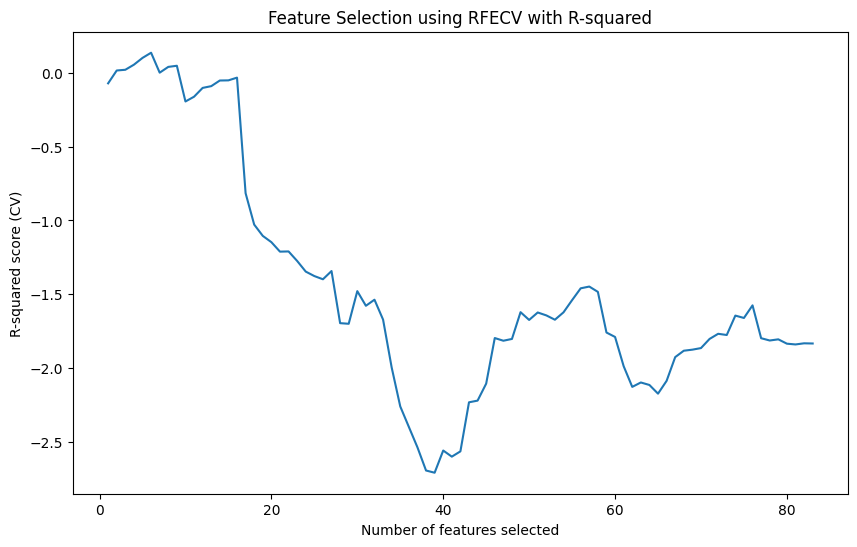

Mean squared error: 0.0847
R-squared score: 0.0178

Coefficients of selected features:
                                             Feature  Coefficient
0  China: Consumer Confidence Index: Employment:P...     1.747541
2  China: Consumer Expectation Index: Employment:...    -1.102556
1  China: Consumer Satisfaction Index: Employment...    -0.644744
4  China: Financial Institutions: New RMB Deposit...     0.464626
5              China: Business Climate Index:PoP chg     0.293017
3  China: Retail Sales of the Enterprises (units)...    -0.184490

Selected feature names have been saved to 'selected_feature_names.txt'


In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from pathlib import Path
import os

project_dir = Path(os.getcwd())
print(project_dir)

# Navigate upwards and into the data folder (adjust as necessary)
data_dir = project_dir / 'Nowcast'/ 'data' / 'data_files' / 'processed_data'

# Load the data
data = pd.read_csv(data_dir / 'deseasonalized_full_data.csv')
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)

# Fit features and target
X = data.drop('China: GDP: Current Prices:PoP GROWTHRATE', axis=1)
y = data['China: GDP: Current Prices:PoP GROWTHRATE']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a LinearRegression estimator
estimator = LinearRegression()

# Create RFECV object
selector = RFECV(estimator, step=1, cv=5, scoring='r2')

# Fit RFECV
selector = selector.fit(X_train_scaled, y_train)

# Get the optimal number of features
n_features_optimal = selector.n_features_

# Get the selected feature mask
feature_mask = selector.support_

# Get the selected feature names
selected_features = X.columns[feature_mask].tolist()

# Print results
print(f"Optimal number of features: {n_features_optimal}")
print(f"Selected features: {selected_features}")

# Plot number of features VS. R-squared score
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(selector.cv_results_['mean_test_score']) + 1), selector.cv_results_['mean_test_score'])
plt.xlabel("Number of features selected")
plt.ylabel("R-squared score (CV)")
plt.title("Feature Selection using RFECV with R-squared")
plt.show()

# Store selected feature names for later reference
selected_feature_names = selected_features

# Use selected features for final model
X_train_selected = X_train_scaled[:, feature_mask]
X_test_selected = X_test_scaled[:, feature_mask]

# Fit final model
final_model = LinearRegression()
final_model.fit(X_train_selected, y_train)

# Make predictions
y_pred = final_model.predict(X_test_selected)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean squared error: {mse:.4f}")
print(f"R-squared score: {r2:.4f}")

# Display coefficients of selected features
coefficients = pd.DataFrame({
    'Feature': selected_feature_names,
    'Coefficient': final_model.coef_
})
print("\nCoefficients of selected features:")
print(coefficients.sort_values(by='Coefficient', key=abs, ascending=False))

# Save selected feature names to a file for future reference
with open('selected_feature_names.txt', 'w') as f:
    for feature in selected_feature_names:
        f.write(f"{feature}\n")

print(f"\nSelected feature names have been saved to 'selected_feature_names.txt'")

In [72]:
import requests
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from tqdm import tqdm
import os

project_dir = Path(os.getcwd())
print(project_dir)

# Navigate upwards and into the data folder (adjust as necessary)
data_dir = project_dir / 'Nowcast'/ 'data' / 'data_files' / 'processed_data'

# Read data
metadata = pd.read_csv(data_dir / 'meta_monthly_blocks_2.csv')
data = pd.read_csv(data_dir / 'deseasonalized_data.csv')
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date').sort_index()

# Function to standardize a single column
def z_score(x):
    return (x - x.mean()) / x.std()

# Assuming 'data' is your DataFrame
normalized = data.copy()

# Apply standardization to all columns except "date"
normalized.loc[:, normalized.columns != 'date'] = normalized.loc[:, normalized.columns != 'date'].apply(z_score)

data = normalized

target_variable = "China: GDP: Current Prices:PoP GROWTHRATE"

selected_data = pd.DataFrame(data, columns=data.columns)[selected_feature_names]
selected_data['China: GDP: Current Prices:PoP GROWTHRATE'] = data[target_variable]
data = selected_data
print(data.info())

/Users/leyixu/Desktop
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 388 entries, 1992-03-31 to 2024-06-30
Data columns (total 7 columns):
 #   Column                                                                               Non-Null Count  Dtype  
---  ------                                                                               --------------  -----  
 0   China: Consumer Confidence Index: Employment:PoP chg                                 376 non-null    float64
 1   China: Consumer Satisfaction Index: Employment:PoP chg                               376 non-null    float64
 2   China: Consumer Expectation Index: Employment:PoP chg                                376 non-null    float64
 3   China: Retail Sales of the Enterprises (units) above Designated Size:PoP GROWTHRATE  376 non-null    float64
 4   China: Financial Institutions: New RMB Deposits:PoP GROWTHRATE                       376 non-null    float64
 5   China: Business Climate Index:PoP chg               

In [74]:
print(data.tail())

            China: Consumer Confidence Index: Employment:PoP chg  \
date                                                               
2024-02-29                                                NaN      
2024-03-31                                                NaN      
2024-04-30                                                NaN      
2024-05-31                                                NaN      
2024-06-30                                                NaN      

            China: Consumer Satisfaction Index: Employment:PoP chg  \
date                                                                 
2024-02-29                                                NaN        
2024-03-31                                                NaN        
2024-04-30                                                NaN        
2024-05-31                                                NaN        
2024-06-30                                                NaN        

            China: Consumer Expe

In [20]:
# Create block structure

# Filter metadata to include only series present in the test dataset
filtered_metadata = metadata[metadata['series'].isin(data.columns)]

# Order rows of filtered_metadata to match the order of columns in the test dataset (excluding the first column)
ordered_series = data.columns
filtered_metadata = filtered_metadata.set_index('series').loc[ordered_series]

# Select columns starting with "block_"
block_columns = [col for col in filtered_metadata.columns if col.startswith('block_')]
blocks = filtered_metadata[block_columns]

# Drop blocks with no loadings
blocks = blocks.loc[:, (blocks != 0).any(axis=0)]

# The index of blocks is already the series names, so we don't need to set it again

# Print the resulting blocks DataFrame for debugging
print(blocks)

                                                    block_g1  block_g2  \
China: Consumer Confidence Index: Employment:Po...         1         1   
China: Consumer Satisfaction Index: Employment:...         1         1   
China: Consumer Expectation Index: Employment:P...         1         1   
China: Retail Sales of the Enterprises (units) ...         1         1   
China: Financial Institutions: New RMB Deposits...         1         1   
China: Business Climate Index:PoP chg                      1         1   
China: GDP: Current Prices:PoP GROWTHRATE                  1         1   

                                                    block_g3  block_g4  \
China: Consumer Confidence Index: Employment:Po...         1         1   
China: Consumer Satisfaction Index: Employment:...         1         1   
China: Consumer Expectation Index: Employment:P...         1         1   
China: Retail Sales of the Enterprises (units) ...         1         1   
China: Financial Institutions: New RM

In [24]:
# Create testing vintage

import pandas as pd
import numpy as np

# Define date ranges
train_start_date = pd.to_datetime('1992-09-30')
test_start_date = pd.to_datetime("2022-06-30")
test_end_date = pd.to_datetime("2023-12-31")
test_dates = pd.date_range(start=test_start_date, end=test_end_date, freq='QE')
print(test_dates)

# Replace infinities with NaN
data.replace([np.inf, -np.inf], np.nan, inplace=True)

DatetimeIndex(['2022-06-30', '2022-09-30', '2022-12-31', '2023-03-31',
               '2023-06-30', '2023-09-30', '2023-12-31'],
              dtype='datetime64[ns]', freq='QE-DEC')


In [27]:
from pandas.tseries.offsets import MonthEnd
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Initialize DataFrame to store predictions
lags = range(0, 4)
pred_dict = pd.DataFrame({'date': test_dates})
pred_dict['date'] = pd.to_datetime(pred_dict['date'])
for lag in lags:
    pred_dict[str(lag)] = np.nan

# Updated function to generate lagged data
def gen_lagged_data(metadata, data, last_date, lag):
    last_date = pd.Timestamp(last_date)  # Ensure last_date is a Timestamp object
    lagged_data = data.loc[data.index <= last_date, :].reset_index()
    for col in lagged_data.columns[1:]:
        pub_lag = metadata.loc[metadata.series == col, "months_lag"].values[0]
        
        lagged_data.loc[(len(lagged_data) - pub_lag - lag):, col] = np.nan

    return lagged_data


for i, test_date in enumerate(test_dates):
    print(f"Processing test date: {test_date}")
    
    test_date = pd.Timestamp(test_date)
    
    # Train the model using data up to the previous month
    previous_month_end = (test_date - pd.offsets.MonthEnd(1))
    
    print(f"Training data ends at: {previous_month_end}")
    
    train = data.loc[:previous_month_end].copy()
    
    for lag in lags:
        #train = data.loc[:previous_month_end].copy()
        print(f"Processing lag: {lag}")
        lagged_train = gen_lagged_data(metadata, train, previous_month_end, lag)
        lagged_train.set_index('date', inplace=True)
        print(lagged_train.tail())
        
        # Set up the DynamicFactorMQ model
        factor_structure = {series: [] for series in lagged_train.columns}
        for col in blocks.columns:
            for series in blocks.index[blocks[col] == 1]:
                factor_structure[series].append(f'factor_{col}')
        
        print(f"Training on data up to: {previous_month_end}, with lag: {lag}")
        
        model = sm.tsa.DynamicFactorMQ(
            endog=lagged_train,
            k_endog_monthly=5,
            factors=factor_structure,
            factor_orders=12,
            initialization='approximate_diffuse',
            idiosyncratic_ar1=True,
        )
        
        # Fit the model
        results = model.fit(disp=True, method='lbfgs', mstep_method='missing', maxiter=50)
    
        # Use the new data up to the current month for making predictions
        current_month_end = test_date
        
        # Generate lagged data for the current month
        lagged_test = gen_lagged_data(metadata, data, current_month_end, lag)
        lagged_test.set_index('date', inplace=True)
        print(lagged_test.tail())
        
        # Calculate the date for the new information based on the lag and ensure it falls on a month end
        new_info_date = (current_month_end - pd.DateOffset(months=lag)) + pd.offsets.MonthEnd(0)
        print(new_info_date)
        
        # Extract only the row corresponding to the new_info_date
        new_information = lagged_test.loc[:new_info_date]
        print(new_information)
        
        # Make predictions for the current test date using the new data
        prediction = results.predict(start=current_month_end, end=current_month_end, exog=new_information)

        # If prediction is empty or doesn't contain the target variable, use the last available date
        if prediction.empty or "China: GDP: Current Prices:PoP GROWTHRATE" not in prediction.columns:
            last_train_date = train.index[-1]
            prediction = results.predict(start=last_train_date, end=last_train_date, exog=new_information)
            print(prediction)
            print(f"Using last training date for prediction: {last_train_date}")
        
        # Extract the prediction for the target variable
        pred_value = prediction["China: GDP: Current Prices:PoP GROWTHRATE"].iloc[-1]
        
        # Store the prediction in pred_dict for the corresponding lag
        pred_dict.loc[pred_dict['date'] == test_date, str(lag)] = pred_value
        print(results.summary())
        print(pred_dict)

        print(f"Predictions for test date {test_date}:")
        print(pred_dict.loc[pred_dict['date'] == test_date])

print("Final pred_dict:")
print(pred_dict)
        
# Extract actual values for the test period
actuals = data.loc[test_start_date:test_end_date, "China: GDP: Current Prices:PoP GROWTHRATE"].dropna()

# Merge predictions with actuals for performance analysis
predictions_vs_actuals = pd.merge(pred_dict, actuals, left_on='date', right_index=True)

print(predictions_vs_actuals)

Processing test date: 2022-06-30 00:00:00
Training data ends at: 2022-05-31 00:00:00
Processing lag: 0
            China: Consumer Confidence Index: Employment:PoP chg  \
date                                                               
2022-01-31                                           0.369763      
2022-02-28                                          -0.161911      
2022-03-31                                          -2.759246      
2022-04-30                                         -10.942702      
2022-05-31                                                NaN      

            China: Consumer Satisfaction Index: Employment:PoP chg  \
date                                                                 
2022-01-31                                           0.275037        
2022-02-28                                          -0.301468        
2022-03-31                                          -2.493768        
2022-04-30                                         -11.199099        


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          114     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05461D+00    |proj g|=  2.06854D+02


 This problem is unconstrained.



At iterate    1    f=  8.36435D-01    |proj g|=  1.28461D+02

At iterate    2    f=  8.25225D-01    |proj g|=  1.07947D+02

At iterate    3    f=  8.00706D-01    |proj g|=  4.04570D+01

At iterate    4    f=  7.92726D-01    |proj g|=  6.97311D+01

At iterate    5    f=  7.54904D-01    |proj g|=  8.67996D+01

At iterate    6    f=  7.09723D-01    |proj g|=  5.37243D+01

At iterate    7    f=  6.91169D-01    |proj g|=  2.14649D+01

At iterate    8    f=  6.87024D-01    |proj g|=  1.57812D+01

At iterate    9    f=  6.83800D-01    |proj g|=  1.44782D+01

At iterate   10    f=  6.56853D-01    |proj g|=  6.95810D+01

At iterate   11    f=  6.49532D-01    |proj g|=  1.94972D+01

At iterate   12    f=  6.41732D-01    |proj g|=  3.04625D+01

At iterate   13    f=  6.38292D-01    |proj g|=  2.02140D+01

At iterate   14    f=  6.36699D-01    |proj g|=  1.29565D+01

At iterate   15    f=  6.34205D-01    |proj g|=  1.51515D+01

At iterate   16    f=  6.27686D-01    |proj g|=  5.53888D+01

At iter

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:608: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


            China: Consumer Confidence Index: Employment:PoP chg  \
date                                                               
2022-02-28                                          -0.161911      
2022-03-31                                          -2.759246      
2022-04-30                                         -10.942702      
2022-05-31                                           0.217982      
2022-06-30                                                NaN      

            China: Consumer Satisfaction Index: Employment:PoP chg  \
date                                                                 
2022-02-28                                          -0.301468        
2022-03-31                                          -2.493768        
2022-04-30                                         -11.199099        
2022-05-31                                          -0.083460        
2022-06-30                                                NaN        

            China: Consumer Expe

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          114     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.25636D-01    |proj g|=  1.86309D+02


 This problem is unconstrained.



At iterate    1    f=  6.12860D-01    |proj g|=  1.37162D+02

At iterate    2    f=  6.04231D-01    |proj g|=  7.07344D+01

At iterate    3    f=  5.96313D-01    |proj g|=  4.89574D+01

At iterate    4    f=  5.91620D-01    |proj g|=  1.09666D+01

At iterate    5    f=  5.90917D-01    |proj g|=  5.95746D+00

At iterate    6    f=  5.89237D-01    |proj g|=  1.54874D+01

At iterate    7    f=  5.86158D-01    |proj g|=  3.08668D+01

At iterate    8    f=  5.77548D-01    |proj g|=  4.56872D+01

At iterate    9    f=  5.62660D-01    |proj g|=  5.84202D+01

At iterate   10    f=  5.43705D-01    |proj g|=  3.54268D+01

At iterate   11    f=  5.22090D-01    |proj g|=  5.87461D+01

At iterate   12    f=  5.18082D-01    |proj g|=  2.23013D+01

At iterate   13    f=  5.12220D-01    |proj g|=  2.36859D+01

At iterate   14    f=  5.05932D-01    |proj g|=  3.64055D+01

At iterate   15    f=  4.92905D-01    |proj g|=  3.29654D+01

At iterate   16    f=  4.68507D-01    |proj g|=  2.13396D+01

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   48    f=  1.36016D-01    |proj g|=  7.35086D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  114     48    143      2     0     0   7.351D+00   1.360D-01
  F =  0.13601631441932677     

STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT        


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:608: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


            China: Consumer Confidence Index: Employment:PoP chg  \
date                                                               
2022-02-28                                          -0.161911      
2022-03-31                                          -2.759246      
2022-04-30                                         -10.942702      
2022-05-31                                                NaN      
2022-06-30                                                NaN      

            China: Consumer Satisfaction Index: Employment:PoP chg  \
date                                                                 
2022-02-28                                          -0.301468        
2022-03-31                                          -2.493768        
2022-04-30                                         -11.199099        
2022-05-31                                                NaN        
2022-06-30                                                NaN        

            China: Consumer Expe

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          114     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.12303D-01    |proj g|=  2.03004D+02

At iterate    1    f=  4.18133D-01    |proj g|=  1.43759D+02

At iterate    2    f=  3.93100D-01    |proj g|=  1.01846D+02

At iterate    3    f=  3.76297D-01    |proj g|=  2.34724D+01

At iterate    4    f=  3.74577D-01    |proj g|=  1.91400D+01

At iterate    5    f=  3.69975D-01    |proj g|=  1.22686D+01

At iterate    6    f=  3.55538D-01    |proj g|=  5.17155D+01

At iterate    7    f=  3.43377D-01    |proj g|=  7.36453D+01

At iterate    8    f=  3.25200D-01    |proj g|=  6.90338D+01

At iterate    9    f=  3.17002D-01    |proj g|=  1.42124D+01

At iterate   10    f=  3.14242D-01    |proj g|=  1.64380D+01

At iterate   11    f=  3.11948D-01    |proj g|=  1.44357D+01

At iterate   12    f=  3.10113D-01    |proj g|=  1.97383D+01

At iterate   13    f=  3.0

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:608: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


            China: Consumer Confidence Index: Employment:PoP chg  \
date                                                               
2022-02-28                                          -0.161911      
2022-03-31                                          -2.759246      
2022-04-30                                                NaN      
2022-05-31                                                NaN      
2022-06-30                                                NaN      

            China: Consumer Satisfaction Index: Employment:PoP chg  \
date                                                                 
2022-02-28                                          -0.301468        
2022-03-31                                          -2.493768        
2022-04-30                                                NaN        
2022-05-31                                                NaN        
2022-06-30                                                NaN        

            China: Consumer Expe

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          114     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.29140D-01    |proj g|=  2.14702D+02


 This problem is unconstrained.



At iterate    1    f=  4.93945D-01    |proj g|=  5.56503D+01

At iterate    2    f=  4.87983D-01    |proj g|=  1.99959D+01

At iterate    3    f=  4.85133D-01    |proj g|=  1.13306D+01

At iterate    4    f=  4.84117D-01    |proj g|=  5.72125D+00

At iterate    5    f=  4.82427D-01    |proj g|=  6.71437D+00

At iterate    6    f=  4.79952D-01    |proj g|=  1.42722D+01

At iterate    7    f=  4.71449D-01    |proj g|=  3.20075D+01

At iterate    8    f=  4.52265D-01    |proj g|=  5.79127D+01

At iterate    9    f=  4.05590D-01    |proj g|=  1.00762D+02

At iterate   10    f=  3.19505D-01    |proj g|=  1.51822D+02

At iterate   11    f=  2.49807D-01    |proj g|=  1.29651D+02

At iterate   12    f=  1.35135D-01    |proj g|=  1.03880D+02

At iterate   13    f=  1.11499D-01    |proj g|=  4.43703D+01

At iterate   14    f=  1.07974D-01    |proj g|=  1.39909D+01

At iterate   15    f=  1.07351D-01    |proj g|=  2.18126D+01

At iterate   16    f=  1.07005D-01    |proj g|=  1.05089D+01

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   44    f= -4.22681D-02    |proj g|=  2.56627D+01

At iterate   45    f= -4.48330D-02    |proj g|=  2.30784D+01

At iterate   46    f= -4.62901D-02    |proj g|=  1.14800D+01

At iterate   47    f= -4.70362D-02    |proj g|=  8.94031D+00

At iterate   48    f= -4.83174D-02    |proj g|=  9.72850D+00

At iterate   49    f= -5.21421D-02    |proj g|=  1.70769D+01


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:608: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)



At iterate   50    f= -5.84205D-02    |proj g|=  2.84741D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  114     50    107      2     0     0   2.847D+01  -5.842D-02
  F =  -5.8420505333841577E-002

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
            China: Consumer Confidence Index: Employment:PoP chg  \
date                                                               
2022-02-28                                          -0.161911      
2022-03-31                                                NaN      
2022-04-30                                                NaN      
2022-05-31           

 This problem is unconstrained.



At iterate    1    f=  6.63251D-01    |proj g|=  1.21905D+02

At iterate    2    f=  6.51727D-01    |proj g|=  9.79538D+01

At iterate    3    f=  6.39379D-01    |proj g|=  1.24501D+02

At iterate    4    f=  6.29680D-01    |proj g|=  3.02980D+01

At iterate    5    f=  6.26487D-01    |proj g|=  2.84225D+01

At iterate    6    f=  6.04701D-01    |proj g|=  9.55907D+01

At iterate    7    f=  5.87165D-01    |proj g|=  7.23902D+01

At iterate    8    f=  5.58109D-01    |proj g|=  1.45501D+01

At iterate    9    f=  5.55668D-01    |proj g|=  3.55856D+01

At iterate   10    f=  5.53429D-01    |proj g|=  1.44648D+01

At iterate   11    f=  5.52005D-01    |proj g|=  9.39092D+00

At iterate   12    f=  5.50107D-01    |proj g|=  2.75383D+01

At iterate   13    f=  5.45392D-01    |proj g|=  5.64327D+01

At iterate   14    f=  5.34639D-01    |proj g|=  6.50774D+01

At iterate   15    f=  5.12540D-01    |proj g|=  3.20825D+01

At iterate   16    f=  4.98037D-01    |proj g|=  3.00690D+01

At iter

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:608: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)



At iterate   50    f=  8.02055D-02    |proj g|=  3.54705D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  114     50     63      1     0     0   3.547D+01   8.021D-02
  F =   8.0205535240621781E-002

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
            China: Consumer Confidence Index: Employment:PoP chg  \
date                                                               
2022-05-31                                           0.217982      
2022-06-30                                           0.955394      
2022-07-31                                          -0.250915      
2022-08-31           

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          114     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.24437D+00    |proj g|=  2.50532D+02

At iterate    1    f=  7.54884D-01    |proj g|=  4.30542D+01

At iterate    2    f=  7.52391D-01    |proj g|=  7.21917D+01

At iterate    3    f=  7.48971D-01    |proj g|=  2.29414D+01

At iterate    4    f=  7.47425D-01    |proj g|=  6.56882D+00

At iterate    5    f=  7.46559D-01    |proj g|=  5.27019D+00

At iterate    6    f=  7.44273D-01    |proj g|=  1.21344D+01

At iterate    7    f=  7.38755D-01    |proj g|=  2.79348D+01

At iterate    8    f=  7.24641D-01    |proj g|=  4.74718D+01

At iterate    9    f=  7.06203D-01    |proj g|=  5.40616D+01

At iterate   10    f=  6.89717D-01    |proj g|=  4.12287D+01

At iterate   11    f=  6.54643D-01    |proj g|=  2.14275D+01

At iterate   12    f=  6.51874D-01    |proj g|=  6.87564D+01

At iterate   13    f=  6.4


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          114     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.24767D-01    |proj g|=  2.09992D+02

At iterate    1    f=  5.73435D-01    |proj g|=  3.45890D+01

At iterate    2    f=  5.69861D-01    |proj g|=  3.48060D+01

At iterate    3    f=  5.59977D-01    |proj g|=  3.23561D+01

At iterate    4    f=  5.11247D-01    |proj g|=  7.39976D+01

At iterate    5    f=  4.89672D-01    |proj g|=  5.58347D+01

At iterate    6    f=  4.75685D-01    |proj g|=  2.15067D+01

At iterate    7    f=  4.74744D-01    |proj g|=  2.70070D+01

At iterate    8    f=  4.72564D-01    |proj g|=  1.20498D+01

At iterate    9    f=  4.69975D-01    |proj g|=  2.55138D+01

At iterate   10    f=  4.63115D-01    |proj g|=  6.50570D+01

At iterate   11    f=  4.47660D-01    |proj g|=  9.15032D+01

At iterate   12    f=  4.31484D-01    |proj g|=  2.36800D+01

At iterate   13    f=  4.2


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


                                        Dynamic Factor Results                                       
Dep. Variable:     "China: Consumer Confiden...", and 6 more   No. Observations:                  366
Model:                                  Dynamic Factor Model   Log Likelihood                 -18.401
                                     + 5 factors in 5 blocks   AIC                            264.801
                                     + Mixed frequency (M/Q)   BIC                            709.702
                                       + AR(1) idiosyncratic   HQIC                           441.592
Date:                                       Fri, 06 Sep 2024                                         
Time:                                               14:31:03                                         
Sample:                                           03-31-1992                                         
                                                - 08-31-2022                      

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          114     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.84923D+00    |proj g|=  6.28187D+01

At iterate    1    f=  1.72575D+00    |proj g|=  4.74153D+01

At iterate    2    f=  1.67417D+00    |proj g|=  4.21614D+01

At iterate    3    f=  1.64988D+00    |proj g|=  4.57834D+01

At iterate    4    f=  1.11562D+00    |proj g|=  6.67264D+01

At iterate    5    f=  9.51244D-01    |proj g|=  7.13910D+01

At iterate    6    f=  8.82898D-01    |proj g|=  6.10469D+01

At iterate    7    f=  8.00639D-01    |proj g|=  7.82230D+01

At iterate    8    f=  7.58006D-01    |proj g|=  1.29458D+02

At iterate    9    f=  7.28025D-01    |proj g|=  3.19741D+01

At iterate   10    f=  6.82960D-01    |proj g|=  3.95810D+01

At iterate   11    f=  6.11715D-01    |proj g|=  1.07186D+02

At iterate   12    f=  5.34874D-01    |proj g|=  9.99688D+01

At iterate   13    f=  5.1


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


            China: Consumer Confidence Index: Employment:PoP chg  \
date                                                               
2022-05-31                                           0.217982      
2022-06-30                                                NaN      
2022-07-31                                                NaN      
2022-08-31                                                NaN      
2022-09-30                                                NaN      

            China: Consumer Satisfaction Index: Employment:PoP chg  \
date                                                                 
2022-05-31                                           -0.08346        
2022-06-30                                                NaN        
2022-07-31                                                NaN        
2022-08-31                                                NaN        
2022-09-30                                                NaN        

            China: Consumer Expe

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          114     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.60567D-01    |proj g|=  2.00422D+02

At iterate    1    f=  7.32534D-01    |proj g|=  1.26033D+02

At iterate    2    f=  7.17689D-01    |proj g|=  9.96894D+01

At iterate    3    f=  6.96429D-01    |proj g|=  3.26261D+01

At iterate    4    f=  6.91133D-01    |proj g|=  4.58762D+01

At iterate    5    f=  6.84940D-01    |proj g|=  5.18513D+01

At iterate    6    f=  6.38740D-01    |proj g|=  7.18857D+01

At iterate    7    f=  6.29107D-01    |proj g|=  7.18458D+01

At iterate    8    f=  6.14842D-01    |proj g|=  1.41771D+01

At iterate    9    f=  6.12731D-01    |proj g|=  1.67069D+01

At iterate   10    f=  6.11506D-01    |proj g|=  9.30084D+00

At iterate   11    f=  6.09677D-01    |proj g|=  1.29314D+01

At iterate   12    f=  6.02932D-01    |proj g|=  3.32053D+01

At iterate   13    f=  5.9

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:608: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


            China: Consumer Confidence Index: Employment:PoP chg  \
date                                                               
2022-07-31                                          -0.250915      
2022-08-31                                          -0.021624      
2022-09-30                                          -0.050106      
2022-10-31                                                NaN      
2022-11-30                                                NaN      

            China: Consumer Satisfaction Index: Employment:PoP chg  \
date                                                                 
2022-07-31                                          -0.393714        
2022-08-31                                           0.420322        
2022-09-30                                          -0.076575        
2022-10-31                                                NaN        
2022-11-30                                                NaN        

            China: Consumer Expe

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          114     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.64371D-01    |proj g|=  2.01230D+02

At iterate    1    f=  7.28504D-01    |proj g|=  1.20732D+02

At iterate    2    f=  7.19042D-01    |proj g|=  1.03475D+02

At iterate    3    f=  6.96594D-01    |proj g|=  3.06121D+01

At iterate    4    f=  6.92042D-01    |proj g|=  4.20398D+01

At iterate    5    f=  6.73554D-01    |proj g|=  5.23896D+01

At iterate    6    f=  6.37163D-01    |proj g|=  5.26544D+01

At iterate    7    f=  6.21933D-01    |proj g|=  4.09849D+01

At iterate    8    f=  6.15093D-01    |proj g|=  1.64325D+01

At iterate    9    f=  6.13163D-01    |proj g|=  8.77361D+00

At iterate   10    f=  6.10150D-01    |proj g|=  1.93045D+01

At iterate   11    f=  6.02949D-01    |proj g|=  5.05193D+01

At iterate   12    f=  5.86805D-01    |proj g|=  2.46843D+01

At iterate   13    f=  5.6


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          114     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.04440D+00    |proj g|=  2.13112D+02


 This problem is unconstrained.



At iterate    1    f=  7.51945D-01    |proj g|=  2.77691D+01

At iterate    2    f=  7.48408D-01    |proj g|=  2.58997D+01

At iterate    3    f=  7.42533D-01    |proj g|=  2.10317D+01

At iterate    4    f=  7.33504D-01    |proj g|=  2.26561D+01

At iterate    5    f=  7.14662D-01    |proj g|=  4.11129D+01

At iterate    6    f=  6.91744D-01    |proj g|=  7.10318D+01

At iterate    7    f=  6.78317D-01    |proj g|=  6.56268D+01

At iterate    8    f=  6.71876D-01    |proj g|=  7.62874D+00

At iterate    9    f=  6.70916D-01    |proj g|=  8.82308D+00

At iterate   10    f=  6.68973D-01    |proj g|=  1.13373D+01

At iterate   11    f=  6.61685D-01    |proj g|=  6.69370D+01

At iterate   12    f=  6.45448D-01    |proj g|=  2.29570D+01

At iterate   13    f=  6.12272D-01    |proj g|=  2.53163D+01

At iterate   14    f=  5.90918D-01    |proj g|=  8.85356D+01

At iterate   15    f=  5.32964D-01    |proj g|=  4.74071D+01

At iterate   16    f=  5.02173D-01    |proj g|=  2.59080D+01

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          114     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.12808D+00    |proj g|=  2.42995D+02

At iterate    1    f=  6.63550D-01    |proj g|=  2.56761D+01

At iterate    2    f=  6.61378D-01    |proj g|=  2.74286D+01

At iterate    3    f=  6.59369D-01    |proj g|=  7.47645D+00

At iterate    4    f=  6.58809D-01    |proj g|=  6.00274D+00

At iterate    5    f=  6.56668D-01    |proj g|=  1.04540D+01

At iterate    6    f=  6.53188D-01    |proj g|=  2.44416D+01

At iterate    7    f=  6.43008D-01    |proj g|=  5.15597D+01

At iterate    8    f=  6.22295D-01    |proj g|=  8.39637D+01

At iterate    9    f=  5.81718D-01    |proj g|=  1.59793D+02

At iterate   10    f=  5.30966D-01    |proj g|=  2.07694D+02

At iterate   11    f=  4.27739D-01    |proj g|=  1.23351D+02

At iterate   12    f=  3.98134D-01    |proj g|=  5.48027D+01

At iterate   13    f=  3.8


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


Processing lag: 0
            China: Consumer Confidence Index: Employment:PoP chg  \
date                                                               
2022-10-31                                          -0.306338      
2022-11-30                                          -1.228632      
2022-12-31                                           1.182446      
2023-01-31                                           1.130957      
2023-02-28                                                NaN      

            China: Consumer Satisfaction Index: Employment:PoP chg  \
date                                                                 
2022-10-31                                          -0.260755        
2022-11-30                                          -1.125196        
2022-12-31                                           0.302856        
2023-01-31                                           1.135648        
2023-02-28                                                NaN        

            Ch

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          114     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.04087D+00    |proj g|=  2.06744D+02

At iterate    1    f=  7.87363D-01    |proj g|=  1.32570D+02

At iterate    2    f=  7.56944D-01    |proj g|=  4.76110D+01

At iterate    3    f=  7.50721D-01    |proj g|=  6.33847D+01

At iterate    4    f=  7.45746D-01    |proj g|=  2.79939D+01

At iterate    5    f=  7.32446D-01    |proj g|=  2.89028D+01

At iterate    6    f=  7.15114D-01    |proj g|=  7.60666D+01

At iterate    7    f=  6.94406D-01    |proj g|=  1.04774D+02

At iterate    8    f=  6.74452D-01    |proj g|=  1.00751D+02

At iterate    9    f=  6.65492D-01    |proj g|=  5.36418D+01

At iterate   10    f=  6.60348D-01    |proj g|=  1.06099D+01

At iterate   11    f=  6.59281D-01    |proj g|=  1.21961D+01

At iterate   12    f=  6.51647D-01    |proj g|=  5.54534D+01

At iterate   13    f=  6.4


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          114     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.11816D+00    |proj g|=  2.09820D+02


 This problem is unconstrained.



At iterate    1    f=  8.36401D-01    |proj g|=  2.65442D+01

At iterate    2    f=  8.32999D-01    |proj g|=  2.19127D+01

At iterate    3    f=  8.28553D-01    |proj g|=  1.84993D+01

At iterate    4    f=  8.21813D-01    |proj g|=  1.74716D+01

At iterate    5    f=  8.06306D-01    |proj g|=  3.59762D+01

At iterate    6    f=  7.84554D-01    |proj g|=  6.61377D+01

At iterate    7    f=  7.71175D-01    |proj g|=  7.62459D+01

At iterate    8    f=  7.59634D-01    |proj g|=  3.04373D+01

At iterate    9    f=  7.57931D-01    |proj g|=  1.10175D+01

At iterate   10    f=  7.57403D-01    |proj g|=  1.01201D+01

At iterate   11    f=  7.55111D-01    |proj g|=  2.34030D+01

At iterate   12    f=  7.50772D-01    |proj g|=  4.42549D+01

At iterate   13    f=  7.38014D-01    |proj g|=  4.15429D+01

At iterate   14    f=  7.28029D-01    |proj g|=  2.15820D+02

At iterate   15    f=  6.99527D-01    |proj g|=  9.33493D+01

At iterate   16    f=  6.65395D-01    |proj g|=  6.10681D+01

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


                                        Dynamic Factor Results                                       
Dep. Variable:     "China: Consumer Confiden...", and 6 more   No. Observations:                  372
Model:                                  Dynamic Factor Model   Log Likelihood                -106.724
                                     + 5 factors in 5 blocks   AIC                            441.448
                                     + Mixed frequency (M/Q)   BIC                            888.202
                                       + AR(1) idiosyncratic   HQIC                           618.866
Date:                                       Fri, 06 Sep 2024                                         
Time:                                               14:49:16                                         
Sample:                                           03-31-1992                                         
                                                - 02-28-2023                      

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          114     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.06940D+00    |proj g|=  2.33646D+02

At iterate    1    f=  6.98041D-01    |proj g|=  2.27126D+01

At iterate    2    f=  6.95761D-01    |proj g|=  2.14675D+01

At iterate    3    f=  6.92125D-01    |proj g|=  1.26481D+01

At iterate    4    f=  6.89299D-01    |proj g|=  1.24424D+01

At iterate    5    f=  6.79190D-01    |proj g|=  2.59982D+01

At iterate    6    f=  6.65956D-01    |proj g|=  5.17332D+01

At iterate    7    f=  6.47657D-01    |proj g|=  8.54111D+01

At iterate    8    f=  6.27032D-01    |proj g|=  9.17768D+01

At iterate    9    f=  6.26861D-01    |proj g|=  8.87447D+01

At iterate   10    f=  6.09943D-01    |proj g|=  2.20929D+01

At iterate   11    f=  6.07875D-01    |proj g|=  1.24207D+01

At iterate   12    f=  6.05763D-01    |proj g|=  1.21939D+01

At iterate   13    f=  5.9


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)



At iterate   45    f=  1.59936D-01    |proj g|=  2.23089D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  114     45     70      1     0     0   2.231D+01   1.599D-01
  F =  0.15993619880524232     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
            China: Consumer Confidence Index: Employment:PoP chg  \
date                                                               
2022-11-30                                          -1.228632      
2022-12-31                                           1.182446      
2023-01-31                                                NaN      
2023-02-28           

 This problem is unconstrained.



At iterate    1    f=  7.06715D-01    |proj g|=  1.17985D+02

At iterate    2    f=  6.99351D-01    |proj g|=  1.04275D+02

At iterate    3    f=  6.76412D-01    |proj g|=  3.07787D+01

At iterate    4    f=  6.71818D-01    |proj g|=  4.28090D+01

At iterate    5    f=  6.66748D-01    |proj g|=  4.55653D+01

At iterate    6    f=  6.17034D-01    |proj g|=  6.39857D+01

At iterate    7    f=  6.03263D-01    |proj g|=  3.87862D+01

At iterate    8    f=  5.97113D-01    |proj g|=  2.31206D+01

At iterate    9    f=  5.95830D-01    |proj g|=  1.21808D+01

At iterate   10    f=  5.95018D-01    |proj g|=  9.99976D+00

At iterate   11    f=  5.91965D-01    |proj g|=  1.35171D+01

At iterate   12    f=  5.85916D-01    |proj g|=  3.13312D+01

At iterate   13    f=  5.72767D-01    |proj g|=  5.16464D+01

At iterate   14    f=  5.48621D-01    |proj g|=  4.85173D+01

At iterate   15    f=  5.34681D-01    |proj g|=  3.97748D+01

At iterate   16    f=  5.28405D-01    |proj g|=  3.21421D+01

At iter

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:608: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          114     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02633D+00    |proj g|=  2.04676D+02


 This problem is unconstrained.



At iterate    1    f=  7.87525D-01    |proj g|=  1.30113D+02

At iterate    2    f=  7.68138D-01    |proj g|=  9.23484D+01

At iterate    3    f=  7.50510D-01    |proj g|=  3.19495D+01

At iterate    4    f=  7.45802D-01    |proj g|=  3.88787D+01

At iterate    5    f=  7.37139D-01    |proj g|=  6.63100D+01

At iterate    6    f=  7.09405D-01    |proj g|=  8.68050D+01

At iterate    7    f=  6.79014D-01    |proj g|=  4.92924D+01

At iterate    8    f=  6.75539D-01    |proj g|=  4.72703D+01

At iterate    9    f=  6.71338D-01    |proj g|=  1.10348D+01

At iterate   10    f=  6.70261D-01    |proj g|=  7.12029D+00

At iterate   11    f=  6.67273D-01    |proj g|=  1.61548D+01

At iterate   12    f=  6.62024D-01    |proj g|=  3.00375D+01

At iterate   13    f=  6.47349D-01    |proj g|=  4.00496D+01

At iterate   14    f=  6.20194D-01    |proj g|=  5.01246D+01

At iterate   15    f=  6.06588D-01    |proj g|=  4.55497D+01

At iterate   16    f=  5.91021D-01    |proj g|=  2.20064D+01

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          114     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02268D+00    |proj g|=  2.08885D+02

At iterate    1    f=  7.62632D-01    |proj g|=  1.21632D+02

At iterate    2    f=  7.53896D-01    |proj g|=  1.03806D+02

At iterate    3    f=  7.40596D-01    |proj g|=  1.24880D+02

At iterate    4    f=  7.30920D-01    |proj g|=  2.86378D+01

At iterate    5    f=  7.28136D-01    |proj g|=  2.65523D+01

At iterate    6    f=  7.15720D-01    |proj g|=  7.59016D+01

At iterate    7    f=  7.03292D-01    |proj g|=  8.46220D+01

At iterate    8    f=  6.68646D-01    |proj g|=  4.62711D+01

At iterate    9    f=  6.62788D-01    |proj g|=  1.49010D+01

At iterate   10    f=  6.60863D-01    |proj g|=  7.69208D+00

At iterate   11    f=  6.59502D-01    |proj g|=  9.78654D+00

At iterate   12    f=  6.56565D-01    |proj g|=  1.27930D+01

At iterate   13    f=  6.4


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


                                        Dynamic Factor Results                                       
Dep. Variable:     "China: Consumer Confiden...", and 6 more   No. Observations:                  375
Model:                                  Dynamic Factor Model   Log Likelihood                 -79.981
                                     + 5 factors in 5 blocks   AIC                            387.963
                                     + Mixed frequency (M/Q)   BIC                            835.632
                                       + AR(1) idiosyncratic   HQIC                           565.690
Date:                                       Fri, 06 Sep 2024                                         
Time:                                               14:59:20                                         
Sample:                                           03-31-1992                                         
                                                - 05-31-2023                      

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          114     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.06033D+00    |proj g|=  2.20432D+02


 This problem is unconstrained.



At iterate    1    f=  7.33751D-01    |proj g|=  2.93342D+01

At iterate    2    f=  7.30711D-01    |proj g|=  1.98048D+01

At iterate    3    f=  7.27010D-01    |proj g|=  2.04853D+01

At iterate    4    f=  7.20938D-01    |proj g|=  1.90478D+01

At iterate    5    f=  7.01420D-01    |proj g|=  3.84722D+01

At iterate    6    f=  6.82532D-01    |proj g|=  5.04976D+01

At iterate    7    f=  6.64012D-01    |proj g|=  5.13190D+01

At iterate    8    f=  6.60028D-01    |proj g|=  1.31399D+01

At iterate    9    f=  6.58577D-01    |proj g|=  1.14701D+01

At iterate   10    f=  6.56529D-01    |proj g|=  1.10561D+01

At iterate   11    f=  6.54619D-01    |proj g|=  2.19844D+01

At iterate   12    f=  6.46765D-01    |proj g|=  4.38422D+01

At iterate   13    f=  6.29524D-01    |proj g|=  6.18879D+01

At iterate   14    f=  5.76716D-01    |proj g|=  4.93134D+01

At iterate   15    f=  5.23981D-01    |proj g|=  6.86852D+01

At iterate   16    f=  5.01133D-01    |proj g|=  3.79065D+01

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   43    f=  2.14070D-01    |proj g|=  1.25451D+01

At iterate   44    f=  2.13286D-01    |proj g|=  1.11212D+01

At iterate   45    f=  2.12643D-01    |proj g|=  9.79370D+00

At iterate   46    f=  2.12106D-01    |proj g|=  1.20806D+01

At iterate   47    f=  2.11102D-01    |proj g|=  2.75529D+01

At iterate   48    f=  2.09271D-01    |proj g|=  3.81319D+01

At iterate   49    f=  2.05280D-01    |proj g|=  5.45877D+01

At iterate   50    f=  2.00311D-01    |proj g|=  5.59223D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  114     50     90      2     0     0   5.592D+01   2.003D-01
  F =  0.200311294921

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:608: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          114     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.16748D+00    |proj g|=  2.33862D+02

At iterate    1    f=  7.70300D-01    |proj g|=  2.25501D+01

At iterate    2    f=  7.67926D-01    |proj g|=  2.29532D+01

At iterate    3    f=  7.66768D-01    |proj g|=  2.56214D+01

At iterate    4    f=  7.64819D-01    |proj g|=  1.00825D+01

At iterate    5    f=  7.63334D-01    |proj g|=  9.05913D+00

At iterate    6    f=  7.59753D-01    |proj g|=  2.36349D+01

At iterate    7    f=  7.52606D-01    |proj g|=  4.93182D+01

At iterate    8    f=  7.36000D-01    |proj g|=  8.90582D+01

At iterate    9    f=  7.16754D-01    |proj g|=  1.08147D+02

At iterate   10    f=  6.91590D-01    |proj g|=  6.29171D+01

At iterate   11    f=  6.79335D-01    |proj g|=  3.64276D+01

At iterate   12    f=  6.73568D-01    |proj g|=  5.03833D+01

At iterate   13    f=  6.6


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


                                        Dynamic Factor Results                                       
Dep. Variable:     "China: Consumer Confiden...", and 6 more   No. Observations:                  375
Model:                                  Dynamic Factor Model   Log Likelihood                -155.072
                                     + 5 factors in 5 blocks   AIC                            538.144
                                     + Mixed frequency (M/Q)   BIC                            985.814
                                       + AR(1) idiosyncratic   HQIC                           715.871
Date:                                       Fri, 06 Sep 2024                                         
Time:                                               15:04:34                                         
Sample:                                           03-31-1992                                         
                                                - 05-31-2023                      

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          114     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03638D+00    |proj g|=  1.98089D+02

At iterate    1    f=  8.06336D-01    |proj g|=  1.33121D+02

At iterate    2    f=  7.67675D-01    |proj g|=  3.31236D+01

At iterate    3    f=  7.62546D-01    |proj g|=  4.53949D+01

At iterate    4    f=  7.37445D-01    |proj g|=  2.83723D+01

At iterate    5    f=  7.03910D-01    |proj g|=  5.12192D+01

At iterate    6    f=  6.88151D-01    |proj g|=  5.51039D+01

At iterate    7    f=  6.85735D-01    |proj g|=  3.50557D+01

At iterate    8    f=  6.82206D-01    |proj g|=  9.12633D+00

At iterate    9    f=  6.81354D-01    |proj g|=  9.40708D+00

At iterate   10    f=  6.72501D-01    |proj g|=  4.08556D+01

At iterate   11    f=  6.61532D-01    |proj g|=  5.03978D+01

At iterate   12    f=  6.38309D-01    |proj g|=  3.14995D+01

At iterate   13    f=  6.3

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:608: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)



At iterate   50    f=  2.43581D-01    |proj g|=  3.39330D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  114     50     63      1     0     0   3.393D+01   2.436D-01
  F =  0.24358062197002878     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
            China: Consumer Confidence Index: Employment:PoP chg  \
date                                                               
2023-05-31                                          -0.162615      
2023-06-30                                          -0.884158      
2023-07-31                                          -0.028900      
2023-08-31           

 This problem is unconstrained.



At iterate    1    f=  8.10202D-01    |proj g|=  1.24498D+02

At iterate    2    f=  7.96404D-01    |proj g|=  1.00331D+02

At iterate    3    f=  7.75335D-01    |proj g|=  2.95997D+01

At iterate    4    f=  7.70905D-01    |proj g|=  4.03918D+01

At iterate    5    f=  7.50867D-01    |proj g|=  6.47332D+01

At iterate    6    f=  7.13192D-01    |proj g|=  4.53400D+01

At iterate    7    f=  7.03494D-01    |proj g|=  3.27910D+01

At iterate    8    f=  7.00643D-01    |proj g|=  1.34716D+01

At iterate    9    f=  6.99115D-01    |proj g|=  8.93155D+00

At iterate   10    f=  6.97901D-01    |proj g|=  9.27847D+00

At iterate   11    f=  6.92991D-01    |proj g|=  1.64563D+01

At iterate   12    f=  6.83542D-01    |proj g|=  3.11961D+01

At iterate   13    f=  6.63522D-01    |proj g|=  3.29855D+01

At iterate   14    f=  6.50287D-01    |proj g|=  1.21646D+02

At iterate   15    f=  6.32339D-01    |proj g|=  4.57787D+01

At iterate   16    f=  6.19140D-01    |proj g|=  2.34377D+01

At iter

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:608: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)



At iterate   50    f=  2.13183D-01    |proj g|=  6.14964D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  114     50     64      1     0     0   6.150D+01   2.132D-01
  F =  0.21318301912212584     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
            China: Consumer Confidence Index: Employment:PoP chg  \
date                                                               
2023-05-31                                          -0.162615      
2023-06-30                                          -0.884158      
2023-07-31                                          -0.028900      
2023-08-31           

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          114     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.24825D+00    |proj g|=  2.40618D+02

At iterate    1    f=  7.88943D-01    |proj g|=  2.73743D+01

At iterate    2    f=  7.86252D-01    |proj g|=  2.29799D+01

At iterate    3    f=  7.84308D-01    |proj g|=  7.90414D+00

At iterate    4    f=  7.83573D-01    |proj g|=  6.87726D+00

At iterate    5    f=  7.80883D-01    |proj g|=  9.95556D+00

At iterate    6    f=  7.77530D-01    |proj g|=  1.74935D+01

At iterate    7    f=  7.65257D-01    |proj g|=  3.41830D+01

At iterate    8    f=  7.41735D-01    |proj g|=  5.82038D+01

At iterate    9    f=  7.12320D-01    |proj g|=  2.00311D+02

At iterate   10    f=  6.63368D-01    |proj g|=  1.50677D+02

At iterate   11    f=  5.78919D-01    |proj g|=  6.10506D+01

At iterate   12    f=  5.69288D-01    |proj g|=  5.18883D+01

At iterate   13    f=  5.6


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   36    f=  3.18734D-01    |proj g|=  4.87987D+00

At iterate   37    f=  3.18583D-01    |proj g|=  6.22807D+00

At iterate   38    f=  3.18028D-01    |proj g|=  1.02765D+01

At iterate   39    f=  3.17310D-01    |proj g|=  2.07944D+01

At iterate   40    f=  3.15391D-01    |proj g|=  3.21697D+01

At iterate   41    f=  3.08777D-01    |proj g|=  4.61441D+01

At iterate   42    f=  2.99664D-01    |proj g|=  4.86411D+01

At iterate   43    f=  2.97028D-01    |proj g|=  4.42144D+01

At iterate   44    f=  2.94301D-01    |proj g|=  2.17287D+01

At iterate   45    f=  2.92897D-01    |proj g|=  8.23798D+00

At iterate   46    f=  2.92880D-01    |proj g|=  4.84751D+00

At iterate   47    f=  2.91689D-01    |proj g|=  6.56043D+00

At iterate   48    f=  2.89523D-01    |proj g|=  6.97316D+00

At iterate   49    f=  2.89172D-01    |proj g|=  7.12012D+00

At iterate   50    f=  2.89116D-01    |proj g|=  1.37731D+01

           * * *

Tit   = total number of iterations
Tnf   = total nu

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:608: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


            China: Consumer Confidence Index: Employment:PoP chg  \
date                                                               
2023-05-31                                          -0.162615      
2023-06-30                                          -0.884158      
2023-07-31                                                NaN      
2023-08-31                                                NaN      
2023-09-30                                                NaN      

            China: Consumer Satisfaction Index: Employment:PoP chg  \
date                                                                 
2023-05-31                                          -0.248962        
2023-06-30                                          -0.841791        
2023-07-31                                                NaN        
2023-08-31                                                NaN        
2023-09-30                                                NaN        

            China: Consumer Expe

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          114     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09185D+00    |proj g|=  2.07038D+02

At iterate    1    f=  8.43989D-01    |proj g|=  1.25288D+02

At iterate    2    f=  8.32478D-01    |proj g|=  1.03024D+02

At iterate    3    f=  8.11670D-01    |proj g|=  3.10272D+01

At iterate    4    f=  8.07212D-01    |proj g|=  4.06659D+01

At iterate    5    f=  8.01416D-01    |proj g|=  5.20738D+01

At iterate    6    f=  7.66862D-01    |proj g|=  6.62930D+01

At iterate    7    f=  7.43745D-01    |proj g|=  4.62700D+01

At iterate    8    f=  7.37044D-01    |proj g|=  2.22385D+01

At iterate    9    f=  7.35305D-01    |proj g|=  7.58896D+00

At iterate   10    f=  7.34160D-01    |proj g|=  9.14041D+00

At iterate   11    f=  7.32159D-01    |proj g|=  1.22847D+01

At iterate   12    f=  7.23431D-01    |proj g|=  3.90374D+01

At iterate   13    f=  7.0

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:608: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.68248D-01    |proj g|=  3.01346D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  114     50     72      1     0     0   3.013D+01   2.682D-01
  F =  0.26824802707290213     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
            China: Consumer Confidence Index: Employment:PoP chg  \
date                                                               
2023-05-31                                          -0.162615      
2023-06-30                                                NaN      
2023-07-31                                                NaN      
2023-08-31           

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          114     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09909D+00    |proj g|=  2.08314D+02

At iterate    1    f=  8.22582D-01    |proj g|=  1.25842D+02

At iterate    2    f=  8.07433D-01    |proj g|=  9.28549D+01

At iterate    3    f=  7.97124D-01    |proj g|=  9.86301D+01

At iterate    4    f=  7.90232D-01    |proj g|=  2.26890D+01

At iterate    5    f=  7.88421D-01    |proj g|=  2.13058D+01

At iterate    6    f=  7.76759D-01    |proj g|=  6.22325D+01

At iterate    7    f=  7.66439D-01    |proj g|=  6.06329D+01

At iterate    8    f=  7.43414D-01    |proj g|=  8.46233D+01

At iterate    9    f=  7.30194D-01    |proj g|=  1.88919D+01

At iterate   10    f=  7.26417D-01    |proj g|=  5.87084D+00

At iterate   11    f=  7.25047D-01    |proj g|=  1.41521D+01

At iterate   12    f=  7.22829D-01    |proj g|=  1.10279D+01

At iterate   13    f=  7.1


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   41    f=  2.71968D-01    |proj g|=  3.18710D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  114     41     64      1     0     0   3.187D+01   2.720D-01
  F =  0.27196793015655252     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
            China: Consumer Confidence Index: Employment:PoP chg  \
date                                                               
2023-08-31                                           0.200391      
2023-09-30                                           0.489073      
2023-10-31                                           0.201125      
2023-11-30           

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          114     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.17689D+00    |proj g|=  2.25120D+02

At iterate    1    f=  7.83290D-01    |proj g|=  2.68729D+01

At iterate    2    f=  7.81822D-01    |proj g|=  1.03482D+01

At iterate    3    f=  7.80356D-01    |proj g|=  1.03237D+01

At iterate    4    f=  7.76829D-01    |proj g|=  1.40251D+01

At iterate    5    f=  7.69533D-01    |proj g|=  2.85467D+01

At iterate    6    f=  7.51933D-01    |proj g|=  5.51256D+01

At iterate    7    f=  7.35362D-01    |proj g|=  8.95970D+01

At iterate    8    f=  7.10351D-01    |proj g|=  7.72264D+01

At iterate    9    f=  7.02175D-01    |proj g|=  3.25332D+01

At iterate   10    f=  6.97356D-01    |proj g|=  1.57863D+01

At iterate   11    f=  6.93546D-01    |proj g|=  1.80730D+01

At iterate   12    f=  6.90743D-01    |proj g|=  1.75205D+01

At iterate   13    f=  6.8

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:608: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)



At iterate   50    f=  3.30364D-01    |proj g|=  4.07595D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  114     50     97      1     0     0   4.076D+01   3.304D-01
  F =  0.33036386511298460     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
            China: Consumer Confidence Index: Employment:PoP chg  \
date                                                               
2023-08-31                                           0.200391      
2023-09-30                                           0.489073      
2023-10-31                                           0.201125      
2023-11-30           

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          114     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.16170D+00    |proj g|=  2.29168D+02

At iterate    1    f=  7.67096D-01    |proj g|=  3.84904D+01

At iterate    2    f=  7.64433D-01    |proj g|=  1.29820D+01

At iterate    3    f=  7.62460D-01    |proj g|=  1.30196D+01

At iterate    4    f=  7.59116D-01    |proj g|=  1.18953D+01

At iterate    5    f=  7.52087D-01    |proj g|=  2.50026D+01

At iterate    6    f=  7.38317D-01    |proj g|=  3.53157D+01

At iterate    7    f=  7.18274D-01    |proj g|=  5.85476D+01

At iterate    8    f=  7.05211D-01    |proj g|=  1.28022D+02

At iterate    9    f=  6.91607D-01    |proj g|=  2.45879D+01

At iterate   10    f=  6.86011D-01    |proj g|=  1.97829D+01

At iterate   11    f=  6.83166D-01    |proj g|=  1.38295D+01

At iterate   12    f=  6.80712D-01    |proj g|=  1.99857D+01

At iterate   13    f=  6.7


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          114     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.07323D+00    |proj g|=  2.15404D+02

At iterate    1    f=  7.61474D-01    |proj g|=  3.37953D+01

At iterate    2    f=  7.58173D-01    |proj g|=  2.30097D+01

At iterate    3    f=  7.53702D-01    |proj g|=  2.23299D+01

At iterate    4    f=  7.37770D-01    |proj g|=  3.23633D+01

At iterate    5    f=  7.17537D-01    |proj g|=  4.62017D+01

At iterate    6    f=  6.94478D-01    |proj g|=  9.18900D+01

At iterate    7    f=  6.84145D-01    |proj g|=  7.77005D+00

At iterate    8    f=  6.82548D-01    |proj g|=  8.65660D+00

At iterate    9    f=  6.80911D-01    |proj g|=  9.40842D+00

At iterate   10    f=  6.77243D-01    |proj g|=  1.32453D+01

At iterate   11    f=  6.65190D-01    |proj g|=  2.76279D+01

At iterate   12    f=  6.44493D-01    |proj g|=  3.85526D+01

At iterate   13    f=  6.0


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


Final pred_dict:
        date         0         1         2         3
0 2022-06-30 -0.330177 -0.640677 -0.203262 -0.062328
1 2022-09-30  0.270343  0.096590  0.415375 -0.882243
2 2022-12-31 -0.633404 -0.428161 -0.572092 -0.475507
3 2023-03-31  0.224030  1.220223 -0.230170 -0.207445
4 2023-06-30  0.139588 -0.043094  0.035599 -0.270550
5 2023-09-30 -0.075887 -0.147772 -0.019383 -0.114340
6 2023-12-31  0.487734  0.085971  0.063243  0.032373
        date         0         1         2         3  \
0 2022-06-30 -0.330177 -0.640677 -0.203262 -0.062328   
1 2022-09-30  0.270343  0.096590  0.415375 -0.882243   
2 2022-12-31 -0.633404 -0.428161 -0.572092 -0.475507   
3 2023-03-31  0.224030  1.220223 -0.230170 -0.207445   
4 2023-06-30  0.139588 -0.043094  0.035599 -0.270550   
5 2023-09-30 -0.075887 -0.147772 -0.019383 -0.114340   
6 2023-12-31  0.487734  0.085971  0.063243  0.032373   

   China: GDP: Current Prices:PoP GROWTHRATE  
0                                  -1.483702  
1               

In [31]:
# Extract actual values for the test period
actuals = data.loc[test_start_date:test_end_date, "China: GDP: Current Prices:PoP GROWTHRATE"]

# Merge predictions with actuals for performance analysis
predictions_vs_actuals = pd.merge(pred_dict, actuals, left_on='date', right_index=True)

print(predictions_vs_actuals)

actuals = actuals.reset_index().dropna()  # Reset the index and drop the old index

actuals.columns = ['date', 'value']  # Adjust column names

        date         0         1         2         3  \
0 2022-06-30 -0.330177 -0.640677 -0.203262 -0.062328   
1 2022-09-30  0.270343  0.096590  0.415375 -0.882243   
2 2022-12-31 -0.633404 -0.428161 -0.572092 -0.475507   
3 2023-03-31  0.224030  1.220223 -0.230170 -0.207445   
4 2023-06-30  0.139588 -0.043094  0.035599 -0.270550   
5 2023-09-30 -0.075887 -0.147772 -0.019383 -0.114340   
6 2023-12-31  0.487734  0.085971  0.063243  0.032373   

   China: GDP: Current Prices:PoP GROWTHRATE  
0                                  -1.483702  
1                                  -0.423762  
2                                  -1.066895  
3                                   0.623754  
4                                  -1.418312  
5                                  -0.895276  
6                                  -0.987230  


RMSE for lag 0: 1.1786


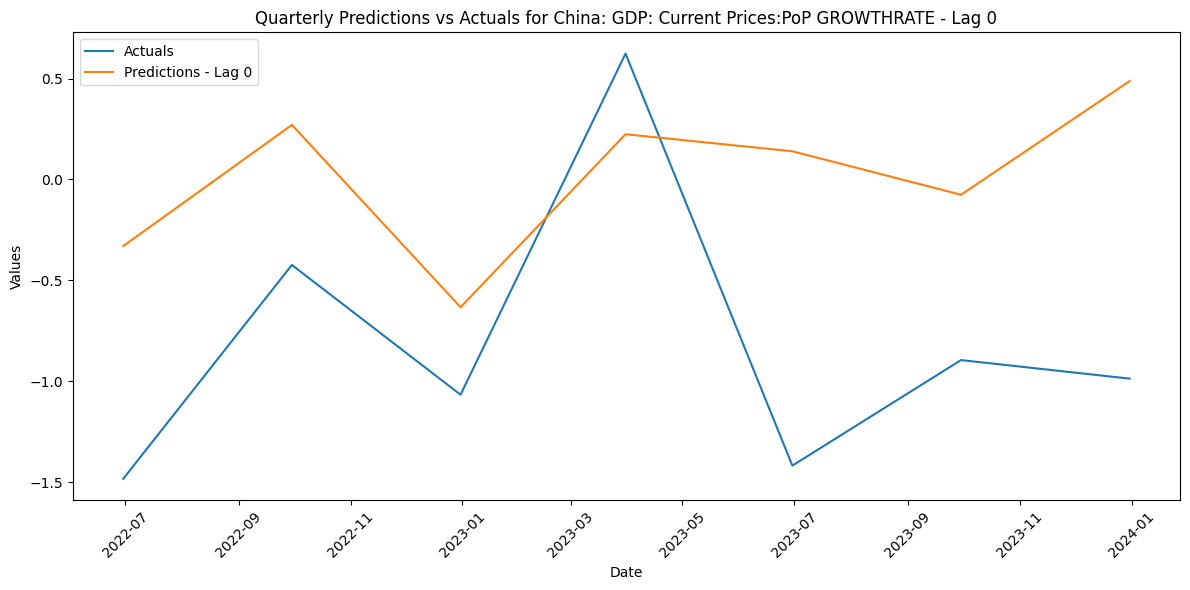

RMSE for lag 1: 1.2573


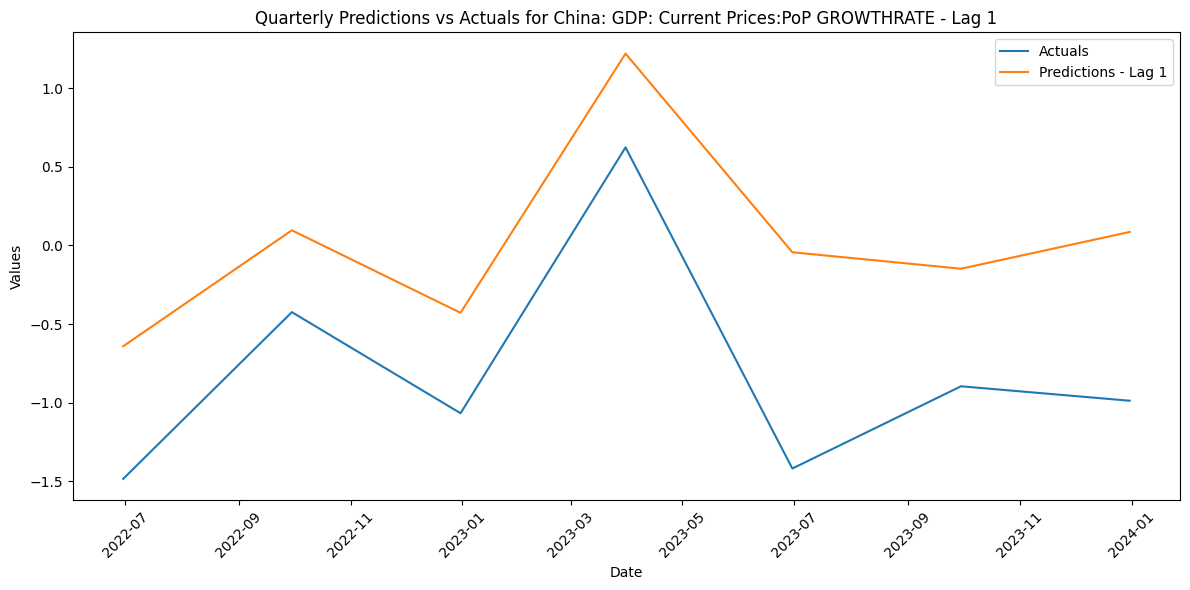

RMSE for lag 2: 0.9923


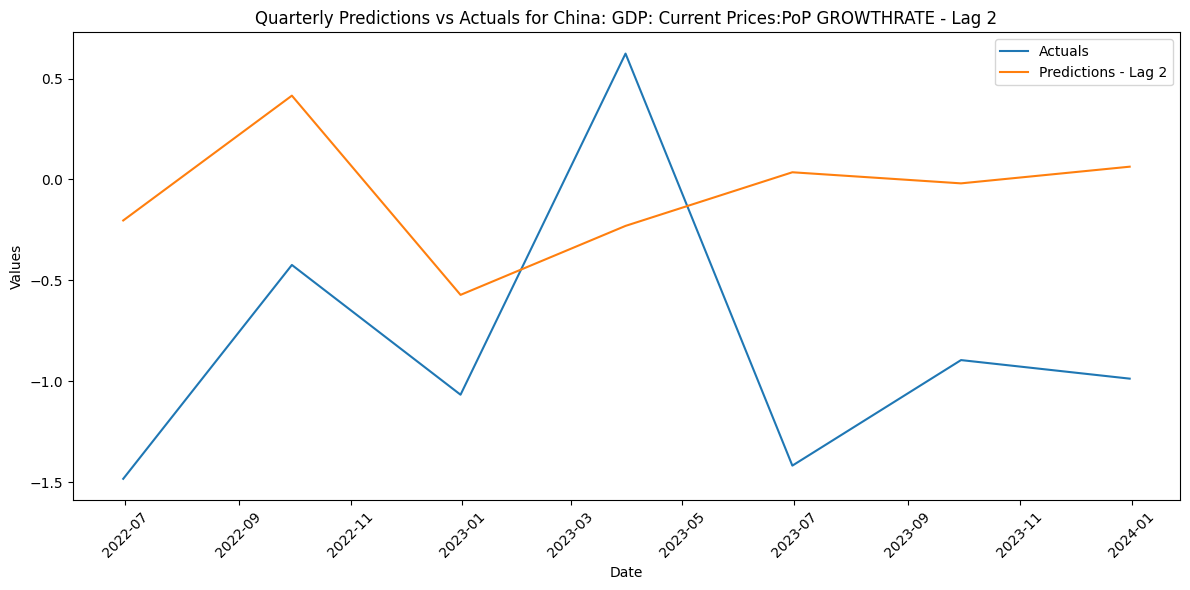

RMSE for lag 3: 1.0449


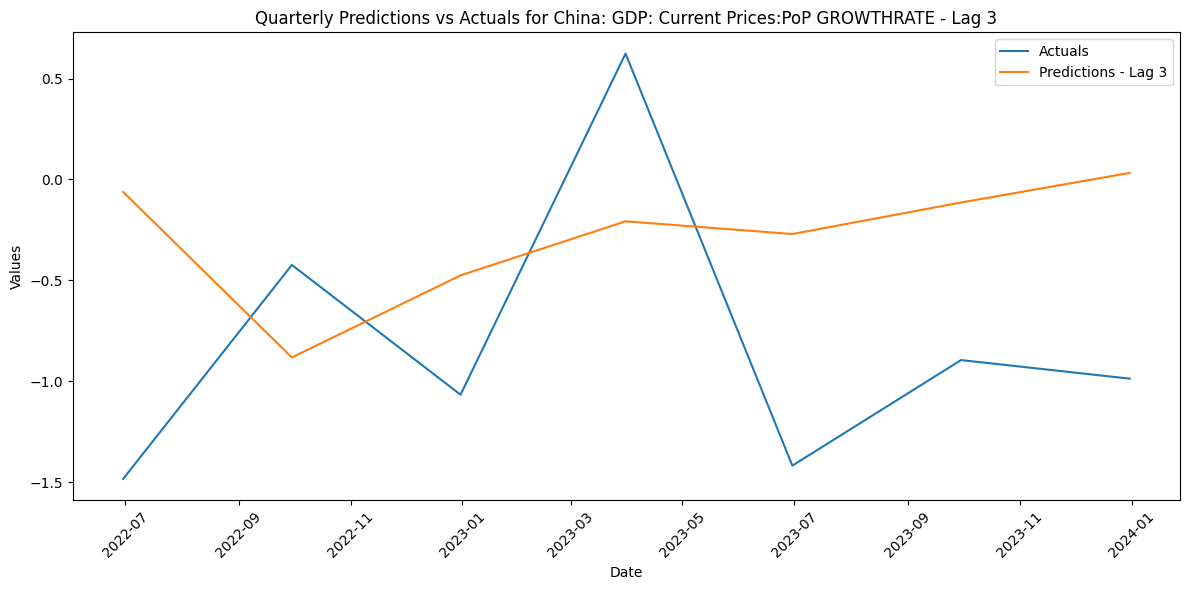

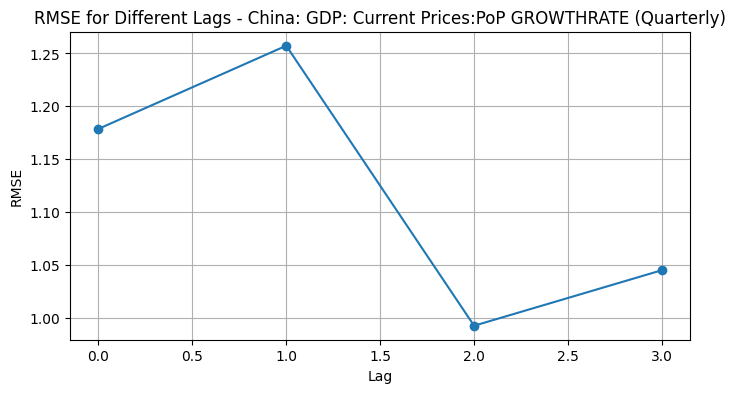

Predictions data saved to dfm_mq_deseason.csv


In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import csv

# Initialize DataFrame to store RMSE for each lag
rmse_dict = {}

# Create a DataFrame to store predictions for all lags
all_predictions = pd.DataFrame({'date': pred_dict['date']})

# Loop through lags and calculate RMSE, prepare for plotting
for lag in lags:
    # Extract the predictions for the current lag
    predictions = pred_dict[['date', str(lag)]].copy()
    predictions.columns = ['date', 'value']
    
    # Add predictions for this lag to all_predictions DataFrame
    all_predictions[f'lag_{lag}'] = predictions['value']
    
    # Ensure predictions are quarterly
    predictions['quarter'] = pd.to_datetime(predictions['date']).dt.to_period('Q')
    quarterly_pred = predictions.groupby('quarter').first().reset_index()
    
    # Prepare actuals (assuming they're already quarterly)
    actuals['quarter'] = pd.to_datetime(actuals['date']).dt.to_period('Q')
    
    # Ensure the quarters of both series match
    common_quarters = set(quarterly_pred['quarter']) & set(actuals['quarter'])
    quarterly_pred = quarterly_pred[quarterly_pred['quarter'].isin(common_quarters)]
    quarterly_actuals = actuals[actuals['quarter'].isin(common_quarters)]
    
    # Calculate RMSE for this lag
    rmse = np.sqrt(np.mean((quarterly_actuals['value'] - quarterly_pred['value'])**2))
    rmse_dict[lag] = rmse
    print(f"RMSE for lag {lag}: {rmse:.4f}")
    
    # Prepare the data for plotting
    plot_data = pd.DataFrame({
        'date': quarterly_actuals['date'],
        'actuals': quarterly_actuals['value'].values,
        f'predictions_lag_{lag}': quarterly_pred['value'].values
    })
    
    # Plot predictions vs actuals for this lag
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=plot_data, x='date', y='actuals', label='Actuals')
    sns.lineplot(data=plot_data, x='date', y=f'predictions_lag_{lag}', label=f'Predictions - Lag {lag}')
    plt.title(f"Quarterly Predictions vs Actuals for {target_variable} - Lag {lag}")
    plt.xlabel("Date")
    plt.ylabel("Values")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Plot RMSE for each lag
plt.figure(figsize=(8, 4))
plt.plot(list(rmse_dict.keys()), list(rmse_dict.values()), marker='o')
plt.title(f"RMSE for Different Lags - {target_variable} (Quarterly)")
plt.xlabel("Lag")
plt.ylabel("RMSE")
plt.grid(True)
plt.show()

# Save predictions to CSV (actual result used for ensemble covers the full test period, this is only for illustration purpose)
csv_filename = 'dfm_mq_deseason.csv'
all_predictions.to_csv(project_dir / 'Nowcast'/ 'results' / csv_filename, index=False)
print(f"Predictions data saved to {csv_filename}")

csv_filename = 'actuals.csv'
actuals.to_csv(project_dir / 'Nowcast'/ 'results' / csv_filename, index=False)
print(f"Predictions data saved to {csv_filename}")